In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from sweref99 import projections
import folium
from folium import plugins
from selenium import webdriver
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output

In [ ]:
path='./data/Insatser till brand i skog och mark 2000-2020.xlsx'

In [ ]:
#tm is used for the conversions of easting and northing to longitude and latitude
tm = projections.make_transverse_mercator("SWEREF_99_TM")

In [381]:
df = pd.read_excel(path)


In [382]:
#Here are our headers!
df['TotArea'] = df['arealProduktivSkogsmark_m2']+df['arealAnnanTradbevuxenMark_m2']+df['arealMarkUtanTrad_m2']
df['Acres'] = df['TotArea']/4046.86
df.head(1)


ar      datum       tid  kommun kommunKortNamn  \
0  2000 2000-01-01  00:07:00    1272       Bromölla   

                           verksamhetText  sweref99Norr  sweref99Ost  \
0  Verksamhet inte knuten till en byggnad        6856.0    -905921.0   

            BEJBbrandorsakText  arealProduktivSkogsmark_m2  \
0  Fyrverkeri eller pyroteknik                           0   

   arealAnnanTradbevuxenMark_m2  arealMarkUtanTrad_m2  TotArea     Acres  
0                             6                     0        6  0.001483

In [383]:
print(df.shape)


(100307, 14)


In [384]:
#Here I copy the dataframe to not have to read the csv files if i accidently overwrites the dataframe.
copy_df = df

In [385]:
#Getting all causes for a fire 
copy_df['BEJBbrandorsakText'].unique()

array(['Fyrverkeri eller pyroteknik', 'Okänd', 'Annan',
       'Barns lek med eld', 'Annan eldning', 'Avsiktlig brand',
       'Övriga gnistor',
       'Återantändning av brand från tidigare räddningsinsats',
       'Självantändning - biologisk eller kemisk',
       'Grillning eller lägereld', 'Blixtnedslag', 'Heta arbeten',
       'Rökning', 'Tågbromsning', 'Fel i utrustning', 'Uppgift saknas'],
      dtype=object)

In [386]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [387]:
#Filter rows on cause of fire and only keeping "Annan". "Okänd", "Grillning eller lägereld" and "Uppgift saknas"
copy_df = filter_rows_by_values(copy_df, 'BEJBbrandorsakText', ['Fyrverkeri eller pyroteknik', 'Annan',
       'Barns lek med eld', 'Annan eldning', 'Avsiktlig brand',
       'Övriga gnistor',
       'Återantändning av brand från tidigare räddningsinsats',
       'Självantändning - biologisk eller kemisk', 'Blixtnedslag', 'Heta arbeten',
       'Rökning', 'Tågbromsning', 'Fel i utrustning', 'Uppgift saknas'])

In [388]:
#I drop all fires smaller than one acre and only keep fires that . I check how many fires are left.
#copy_df = copy_df[copy_df.Acres>1]
#copy_df = copy_df
print(copy_df.shape)

(45922, 14)


In [389]:
#To not get to many values I have made a random sample of X fires.
sample = copy_df#.sample(25, replace=True)

In [390]:
for column in sample:
    if sample[column].isnull().any():
       print('{0} has {1} null values'.format(column, sample[column].isnull().sum()))

sweref99Norr has 9118 null values
sweref99Ost has 9117 null values


In [391]:
#Function that calculates number of missing data in column of dataframe and prints result.
def missing(df,column):
       x = len(df)
       if df[column].isnull().any():
           print('{0} has total of {1} null values'.format(column, df[column].isnull().sum()))
           print ('In the column {0}'.format(column), round(100-(df[column].count()/x * 100), 3), '% of the cells have missing values')
 

In [392]:
#Missing values of column:
missing(sample,'sweref99Norr')
missing(sample,'sweref99Ost')
sample.isnull().sum(axis = 0)

sweref99Norr has total of 9118 null values
In the column sweref99Norr 19.855 % of the cells have missing values
sweref99Ost has total of 9117 null values
In the column sweref99Ost 19.853 % of the cells have missing values


ar                              0
datum                           0
tid                             0
kommun                          0
kommunKortNamn                  0
                               ..
arealProduktivSkogsmark_m2      0
arealAnnanTradbevuxenMark_m2    0
arealMarkUtanTrad_m2            0
TotArea                         0
Acres                           0
Length: 14, dtype: int64

In [393]:
#Functions for converting easting and northing to latitudes and longitudes.
def toLat(E,N):
    lat, lon = tm.grid_to_geodetic(N,E)
    return lat
def toLon(E,N):
    lat, lon = tm.grid_to_geodetic(N,E)
    return lon

In [394]:
#Applying functions to create to new columns, Longitude and Latitude for reported fires.
sample['Latitude'] = sample.apply(lambda row: toLat(row['sweref99Ost'],row['sweref99Norr']),axis=1)
sample['Longitude'] = sample.apply(lambda row: toLon(row['sweref99Ost'],row['sweref99Norr']),axis=1)

C:\Users\Johan\AppData\Local\Temp/ipykernel_11868/1364981563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Latitude'] = sample.apply(lambda row: toLat(row['sweref99Ost'],row['sweref99Norr']),axis=1)
C:\Users\Johan\AppData\Local\Temp/ipykernel_11868/1364981563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Longitude'] = sample.apply(lambda row: toLon(row['sweref99Ost'],row['sweref99Norr']),axis=1)


In [395]:
#We need to group fire sizes here but what sizes should we use? What is a "big" fire and what is a "small" fire?
sample['TotArea'].describe()

count    4.592200e+04
mean     2.839255e+03
std      5.302926e+04
min      0.000000e+00
25%      4.000000e+00
50%      2.200000e+01
75%      2.000000e+02
max      5.500000e+06
Name: TotArea, dtype: float64

In [396]:
sample

ar      datum       tid  kommun kommunKortNamn  \
1       2000 2000-01-01  01:04:00    1452        Tranemo   
3       2000 2000-01-02  19:35:00     180      Stockholm   
5       2000 2000-01-04  23:07:00    1493      Mariestad   
6       2000 2000-01-05  15:57:00    1442       Vårgårda   
7       2000 2000-01-08  20:07:00    1292      Ängelholm   
...      ...        ...       ...     ...            ...   
100289  2020 2020-12-14  18:57:00    1480       Göteborg   
100290  2020 2020-12-17  12:41:00     862       Emmaboda   
100292  2020 2020-12-19  21:20:00    2182      Söderhamn   
100298  2020 2020-12-27  08:47:00     138         Tyresö   
100304  2020 2020-12-30  12:32:00     380        Uppsala   

                                verksamhetText  sweref99Norr  sweref99Ost  \
1       Verksamhet inte knuten till en byggnad           NaN          NaN   
3       Verksamhet inte knuten till en byggnad           NaN          NaN   
5       Verksamhet inte knuten till en byggnad     6502493.0     437254.0   
6       Verksamhet inte knuten till en byggnad     6436766.0     374071.0   
7       Verksamhet inte knuten till en byggnad           NaN          NaN   
...                                        ...           ...          ...   
100289  Verksamhet inte knuten till en byggnad     6403383.0     323691.0   
100290  Verksamhet inte knuten till en byggnad     6279744.0     530642.0   
100292  Verksamhet inte knuten till en byggnad     6804987.0     604088.0   
100298  Verksamhet inte knuten till en byggnad     6570239.0     686650.0   
100304  Verksamhet inte knuten till en byggnad     6637240.0     653312.0   

       BEJBbrandorsakText  arealProduktivSkogsmark_m2  \
1                   Okänd                           0   
3                   Okänd                           0   
5                   Okänd                           0   
6                   Okänd                           0   
7                   Okänd                           0   
...                   ...                         ...   
100289              Okänd                           0   
100290              Okänd                           2   
100292              Okänd                           0   
100298              Okänd                           0   
100304              Okänd                           0   

        arealAnnanTradbevuxenMark_m2  arealMarkUtanTrad_m2  TotArea     Acres  \
1                                  0                     5        5  0.001236   
3                                  5                     0        5  0.001236   
5                                  2                     0        2  0.000494   
6                                  0                    10       10  0.002471   
7                                 10                     0       10  0.002471   
...                              ...                   ...      ...       ...   
100289                             1                     0        1  0.000247   
100290                             0                     0        2  0.000494   
100292                             0                     1        1  0.000247   
100298                             2                     0        2  0.000494   
100304                             0                    20       20  0.004942   

         Latitude  Longitude  
1             NaN        NaN  
3             NaN        NaN  
5       58.658144  13.918530  
6       58.054481  12.866095  
7             NaN        NaN  
...           ...        ...  
100289  57.737881  12.038273  
100290  56.660832  15.499877  
100292  61.364916  16.947073  
100298  59.229959  18.271463  
100304  59.844320  17.736298  

[45922 rows x 16 columns]

In [397]:
#New df for dates and fires
firesAndDates = pd.DataFrame(columns=['datum','fires'])

In [398]:
#Set dates column to the datum columns from the sample
firesAndDates['datum'] = sample['datum']

In [399]:
#Set month and year column to month and year values from datum column
firesAndDates['Month'] = firesAndDates['datum'].dt.month
firesAndDates['Year'] = firesAndDates['datum'].dt.year

In [400]:
#Set all values for fires column to 1
firesAndDates= firesAndDates.assign(fires=1)

In [401]:
firesAndDates['day'] = firesAndDates['datum'].dt.day
firesAndDates['month'] = firesAndDates['datum'].dt.month


In [402]:
firesAndDates

datum  fires  Month  Year  day  month
1      2000-01-01      1      1  2000    1      1
3      2000-01-02      1      1  2000    2      1
5      2000-01-04      1      1  2000    4      1
6      2000-01-05      1      1  2000    5      1
7      2000-01-08      1      1  2000    8      1
...           ...    ...    ...   ...  ...    ...
100289 2020-12-14      1     12  2020   14     12
100290 2020-12-17      1     12  2020   17     12
100292 2020-12-19      1     12  2020   19     12
100298 2020-12-27      1     12  2020   27     12
100304 2020-12-30      1     12  2020   30     12

[45922 rows x 6 columns]

In [403]:
fires_month = pd.DataFrame(columns=['Month','Sum'])
fires_month

Empty DataFrame
Columns: [Month, Sum]
Index: []

In [404]:

fires_month['Sum'] = firesAndDates['Month'].value_counts().to_frame()


In [405]:
fires_day_month = pd.DataFrame(columns=['month_name','Sum'])
fires_day_month

Empty DataFrame
Columns: [month_name, Sum]
Index: []

In [406]:
fires_day_month['Sum'] = firesAndDates.value_counts(['day','month','Year']).to_frame()

In [407]:
#GHEHRHERHERHERHERHERH
fires_day_month = fires_day_month.reset_index()

In [408]:
fires_month

Month   Sum
5    NaN  9861
4    NaN  8430
6    NaN  8029
7    NaN  6943
8    NaN  4388
..   ...   ...
10   NaN  1768
11   NaN   441
1    NaN   224
12   NaN   221
2    NaN   218

[12 rows x 2 columns]

In [409]:
fires_month['Month_num'] = fires_month.index
fires_month

Month   Sum  Month_num
5    NaN  9861          5
4    NaN  8430          4
6    NaN  8029          6
7    NaN  6943          7
8    NaN  4388          8
..   ...   ...        ...
10   NaN  1768         10
11   NaN   441         11
1    NaN   224          1
12   NaN   221         12
2    NaN   218          2

[12 rows x 3 columns]

In [410]:
month_labels = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}


In [411]:
fires_month['Month'] = fires_month['Month_num'].apply(lambda x: month_labels[x])

In [412]:
fires_day_month['month_name'] = fires_day_month['month'].apply(lambda x: month_labels[x])

In [413]:
fires_day_month

day  month  Year month_name  Sum
0      22      5  2019        May  161
1      20      4  2003        Apr  123
2      21      4  2003        Apr   99
3       9      6  2008        Jun   91
4      10      6  2008        Jun   90
...   ...    ...   ...        ...  ...
5103   15      9  2006        Sep    1
5104   19      4  2016        Apr    1
5105   15      9  2001        Sep    1
5106   15      8  2013        Aug    1
5107    1      1  2000        Jan    1

[5108 rows x 5 columns]

In [414]:
fires_month

Month   Sum  Month_num
5    May  9861          5
4    Apr  8430          4
6    Jun  8029          6
7    Jul  6943          7
8    Aug  4388          8
..   ...   ...        ...
10   Oct  1768         10
11   Nov   441         11
1    Jan   224          1
12   Dec   221         12
2    Feb   218          2

[12 rows x 3 columns]

In [415]:
fires_month.sort_values(by=['Month_num'], inplace=True)
fires_month = fires_month.reset_index(drop=True)
fires_month

Month   Sum  Month_num
0    Jan   224          1
1    Feb   218          2
2    Mar  2163          3
3    Apr  8430          4
4    May  9861          5
..   ...   ...        ...
7    Aug  4388          8
8    Sep  3236          9
9    Oct  1768         10
10   Nov   441         11
11   Dec   221         12

[12 rows x 3 columns]

In [416]:
fires_month.drop(columns=['Month_num'], inplace=True)


In [417]:
fires_month

Month   Sum
0    Jan   224
1    Feb   218
2    Mar  2163
3    Apr  8430
4    May  9861
..   ...   ...
7    Aug  4388
8    Sep  3236
9    Oct  1768
10   Nov   441
11   Dec   221

[12 rows x 2 columns]

In [418]:
plt.rcParams["figure.figsize"] = (18,8)

In [419]:
firesAndDates

datum  fires  Month  Year  day  month
1      2000-01-01      1      1  2000    1      1
3      2000-01-02      1      1  2000    2      1
5      2000-01-04      1      1  2000    4      1
6      2000-01-05      1      1  2000    5      1
7      2000-01-08      1      1  2000    8      1
...           ...    ...    ...   ...  ...    ...
100289 2020-12-14      1     12  2020   14     12
100290 2020-12-17      1     12  2020   17     12
100292 2020-12-19      1     12  2020   19     12
100298 2020-12-27      1     12  2020   27     12
100304 2020-12-30      1     12  2020   30     12

[45922 rows x 6 columns]

In [420]:
fires_month

Month   Sum
0    Jan   224
1    Feb   218
2    Mar  2163
3    Apr  8430
4    May  9861
..   ...   ...
7    Aug  4388
8    Sep  3236
9    Oct  1768
10   Nov   441
11   Dec   221

[12 rows x 2 columns]

In [421]:

fig = fires_day_month.groupby(['month','Year']).sum().unstack()
fig

day                                                                 \
Year    2000   2001   2002   2003   2004   2005   2006   2007   2008   2009   
month                                                                         
1      243.0   48.0  192.0  177.0   45.0  118.0   64.0   44.0   63.0  116.0   
2      139.0  145.0  167.0  108.0   95.0   52.0   23.0   32.0  257.0   61.0   
3      426.0  333.0  439.0  430.0  372.0  243.0   19.0  322.0  304.0  296.0   
4      453.0  409.0  465.0  453.0  465.0  449.0  436.0  442.0  444.0  465.0   
5      496.0  496.0  496.0  490.0  496.0  496.0  445.0  496.0  496.0  496.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
8      459.0  410.0  496.0  474.0  492.0  369.0  465.0  496.0  347.0  467.0   
9      437.0  261.0  465.0  465.0  324.0  465.0  437.0  360.0  301.0  432.0   
10     199.0  225.0  496.0  477.0  214.0  391.0   81.0  359.0  282.0  328.0   
11     131.0  204.0  262.0  288.0  146.0  261.0    NaN  131.0   70.0  100.0   
12      60.0   97.0  189.0  106.0   97.0   95.0   38.0   68.0   72.0    8.0   

       ...    Sum                                                          \
Year   ...   2011   2012   2013   2014   2015   2016   2017   2018   2019   
month  ...                                                                  
1      ...    NaN    7.0    NaN    9.0    6.0   18.0   24.0   12.0   22.0   
2      ...    8.0    8.0    4.0    7.0    2.0   21.0   31.0    6.0   17.0   
3      ...   30.0  123.0  128.0   71.0   77.0   90.0  165.0   24.0   57.0   
4      ...  354.0  131.0  266.0  327.0  244.0  195.0  309.0  244.0  789.0   
5      ...  387.0  270.0  368.0  307.0  110.0  557.0  880.0  819.0  611.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
8      ...  114.0  112.0  252.0  182.0  324.0  258.0  241.0  323.0  204.0   
9      ...   42.0   36.0  233.0  172.0   79.0  313.0   43.0  131.0  107.0   
10     ...   26.0   10.0  148.0   50.0  108.0  261.0   29.0  146.0   50.0   
11     ...   13.0    7.0   15.0   12.0   57.0   36.0   17.0   47.0    9.0   
12     ...   20.0    2.0   19.0    4.0   15.0   34.0   10.0   21.0   11.0   

              
Year    2020  
month         
1       37.0  
2       15.0  
3      114.0  
4      499.0  
5      394.0  
...      ...  
8      431.0  
9      188.0  
10      65.0  
11      25.0  
12      11.0  

[12 rows x 42 columns]

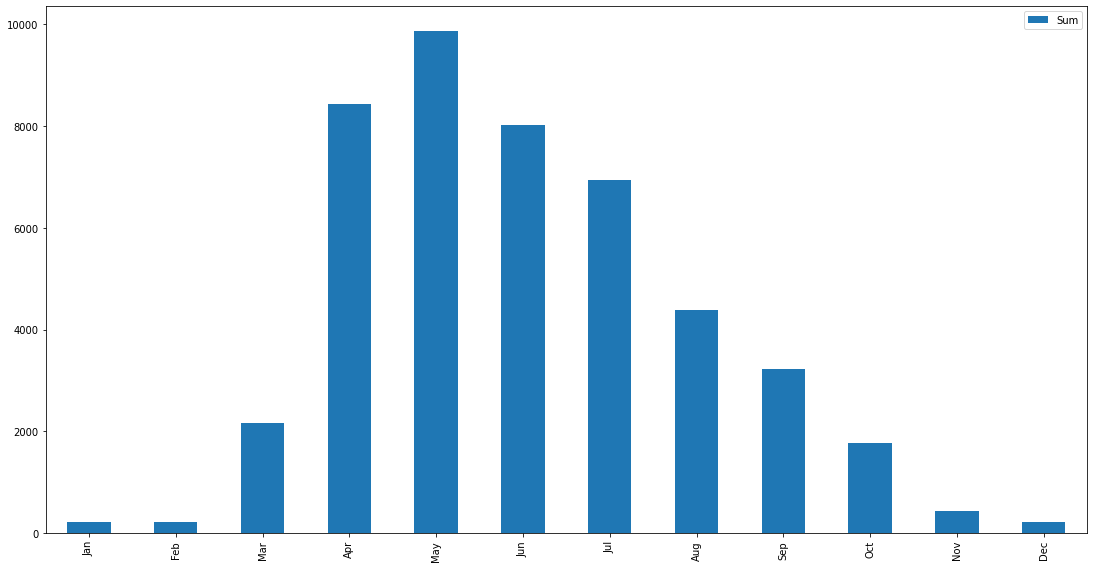

In [422]:
ax = fires_month.plot(kind="bar")
ax.set_xticklabels(fires_month['Month'].values)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [423]:
line = fig.plot(kind='line',y='fires', stacked=True)
line.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
line.set_xticklabels(fires_month['Month'].values)
line.legend(loc='center right')

#Wierd graph, maybe 15 day rolling median to show data in a better more "fair" way?

KeyError: 'fires'

In [ ]:
ss= fires_day_month.head(2)

In [ ]:
fires_day_month.dtypes

day            int64
month          int64
Year           int64
month_name    object
Sum            int64
dtype: object

In [ ]:
def dt_to_datetime(df,column):
        print(df['Year'],df['month'],df['day'])
        #df[column] = datetime(df['Year'],df['month'],df['day'])
        

In [ ]:
fires_day_month['date'] = pd.to_datetime({'year':fires_day_month['Year'],'month': fires_day_month['month'],'day':fires_day_month['day']})
fires_day_month['yday'] = fires_day_month['date'].dt.dayofyear
fires_day_month.sort_values('yday')

day  month  Year month_name  Sum       date  yday
5107    1      1  2000        Jan    1 2000-01-01     1
3838    1      1  2010        Jan    2 2010-01-01     1
3808    1      1  2016        Jan    2 2016-01-01     1
3805    1      1  2014        Jan    2 2014-01-01     1
1348    1      1  2020        Jan   11 2020-01-01     1
...   ...    ...   ...        ...  ...        ...   ...
3820   31     12  2018        Dec    2 2018-12-31   365
4251   30     12  2016        Dec    1 2016-12-30   365
1951   31     12  2016        Dec    7 2016-12-31   366
3147   31     12  2008        Dec    3 2008-12-31   366
3828   31     12  2004        Dec    2 2004-12-31   366

[5108 rows x 7 columns]

In [ ]:
#You are here
tablesplit = fires_day_month.set_index(['date'])
pre2019 = tablesplit.loc['2000-1-1':'2018-12-31']
pre2019['year_group'] = '2000-2018'
post2018 = tablesplit.loc['2019-1-1' : '2020-12-31']
post2018['year_group'] = '2019-2020 '
fires12to18 = tablesplit.loc['2012-1-1' : '2018-12-31']
post2018.sort_values(by='yday')
fires_day_month_v2 = pd.concat([pre2019,post2018])


In [ ]:
fires_day_month_v2= fires_day_month_v2.reset_index()
fires_day_month_v2 = fires_day_month_v2.sort_values(by='date')

In [ ]:
#Creates two tables. One is between 2000 and 2018 (before disposable grill ban), and the second is 2019-2020 (after disposable grill ban)
fires_day_month_v2['rol7'] = fires_day_month_v2[['date','Sum']].rolling(7).mean()
fires_day_month_v2.head(10)

level_0  index       date  day  month  Year month_name  Sum  yday  \
4569     4569   4569 2000-01-01    1      1  2000        Jan    1     1   
3690     3690   3690 2000-01-02    2      1  2000        Jan    1     2   
3853     3853   3853 2000-01-04    4      1  2000        Jan    1     4   
3647     3647   3647 2000-01-05    5      1  2000        Jan    1     5   
4531     4531   4531 2000-01-08    8      1  2000        Jan    1     8   
4468     4468   4468 2000-01-15   15      1  2000        Jan    1    15   
2988     2988   2988 2000-01-16   16      1  2000        Jan    3    16   
3535     3535   3535 2000-01-17   17      1  2000        Jan    2    17   
2282     2282   2282 2000-01-18   18      1  2000        Jan    4    18   
3526     3526   3526 2000-01-20   20      1  2000        Jan    2    20   

     year_group      rol7  
4569  2000-2018       NaN  
3690  2000-2018       NaN  
3853  2000-2018       NaN  
3647  2000-2018       NaN  
4531  2000-2018       NaN  
4468  2000-2018       NaN  
2988  2000-2018  1.285714  
3535  2000-2018  1.428571  
2282  2000-2018  1.857143  
3526  2000-2018  2.000000

In [ ]:
fig3 = fires_day_month.groupby(['yday','Year']).sum().unstack()
fig3

day                                                   ...  Sum       \
Year 2000 2001  2002 2003  2004 2005 2006  2007  2008 2009  ... 2011 2012   
yday                                                        ...             
1     1.0  NaN   NaN  NaN   1.0  NaN  NaN   NaN   1.0  1.0  ...  NaN  2.0   
2     2.0  2.0   NaN  NaN   NaN  2.0  2.0   2.0   NaN  NaN  ...  NaN  NaN   
3     NaN  3.0   NaN  3.0   NaN  3.0  NaN   NaN   NaN  NaN  ...  NaN  NaN   
4     4.0  NaN   NaN  NaN   NaN  NaN  NaN   NaN   4.0  4.0  ...  NaN  NaN   
5     5.0  NaN   NaN  NaN   NaN  5.0  NaN   NaN   NaN  5.0  ...  NaN  NaN   
...   ...  ...   ...  ...   ...  ...  ...   ...   ...  ...  ...  ...  ...   
362   NaN  NaN  28.0  NaN   NaN  NaN  NaN   NaN   NaN  NaN  ...  3.0  NaN   
363   NaN  NaN   NaN  NaN  28.0  NaN  NaN  29.0  28.0  NaN  ...  NaN  NaN   
364   NaN  NaN   NaN  NaN   NaN  NaN  NaN   NaN   NaN  NaN  ...  1.0  NaN   
365   NaN  NaN   NaN  NaN   NaN  NaN  NaN  31.0   NaN  NaN  ...  2.0  NaN   
366   NaN  NaN   NaN  NaN  31.0  NaN  NaN   NaN  31.0  NaN  ...  NaN  NaN   

                                               
Year 2013 2014 2015 2016 2017 2018 2019  2020  
yday                                           
1     NaN  2.0  NaN  2.0  3.0  1.0  3.0  11.0  
2     NaN  NaN  NaN  3.0  3.0  NaN  3.0   2.0  
3     NaN  NaN  1.0  NaN  2.0  NaN  5.0   2.0  
4     NaN  NaN  3.0  1.0  NaN  1.0  2.0   3.0  
5     NaN  NaN  NaN  NaN  1.0  NaN  1.0   NaN  
...   ...  ...  ...  ...  ...  ...  ...   ...  
362   NaN  NaN  NaN  4.0  NaN  1.0  NaN   1.0  
363   3.0  NaN  NaN  NaN  1.0  1.0  NaN   NaN  
364   1.0  NaN  1.0  5.0  NaN  NaN  NaN   NaN  
365   2.0  NaN  NaN  1.0  1.0  2.0  4.0   1.0  
366   NaN  NaN  NaN  7.0  NaN  NaN  NaN   NaN  

[366 rows x 63 columns]

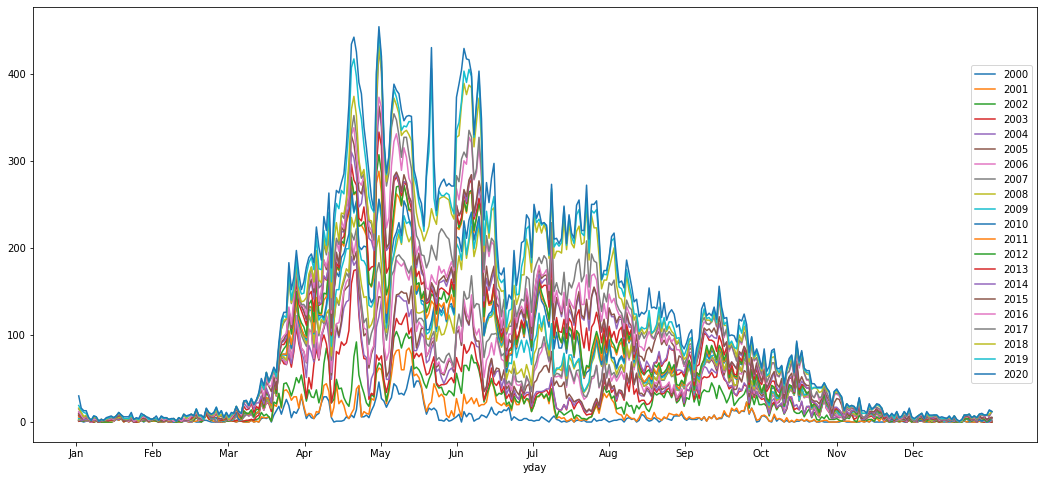

In [ ]:

line = fig3.plot(kind='line',y='Sum', stacked=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
#line.set_xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
#line.set_xticklabels(fires_month['Month'].values)
line.legend(loc='center right')


In [ ]:
fig4 = fires_day_month_v2.groupby(['yday','year_group']).median().unstack()
fig4

level_0                index                  day             \
year_group 2000-2018 2019-2020  2000-2018 2019-2020  2000-2018 2019-2020    
yday                                                                        
1             3501.5     4824.0    3501.5     4824.0       1.0        1.0   
2             3691.0     4966.5    3691.0     4966.5       2.0        2.0   
3             3939.0     4915.5    3939.0     4915.5       3.0        3.0   
4             3853.5     4950.0    3853.5     4950.0       4.0        4.0   
5             3643.0     5012.0    3643.0     5012.0       5.0        5.0   
...              ...        ...       ...        ...       ...        ...   
362           3292.0     5013.0    3292.0     5013.0      28.0       27.0   
363           3864.0        NaN    3864.0        NaN      29.0        NaN   
364           3788.0        NaN    3788.0        NaN      30.0        NaN   
365           3586.0     4957.5    3586.0     4957.5      31.0       30.5   
366           2787.0        NaN    2787.0        NaN      31.0        NaN   

               month                 Year                  Sum             \
year_group 2000-2018 2019-2020  2000-2018 2019-2020  2000-2018 2019-2020    
yday                                                                        
1                1.0        1.0    2011.0     2019.5       1.5        7.0   
2                1.0        1.0    2006.0     2019.5       1.0        2.5   
3                1.0        1.0    2005.0     2019.5       1.0        3.5   
4                1.0        1.0    2012.0     2019.5       1.0        2.5   
5                1.0        1.0    2007.0     2019.0       1.0        1.0   
...              ...        ...       ...        ...       ...        ...   
362             12.0       12.0    2013.5     2020.0       2.0        1.0   
363             12.0        NaN    2010.5        NaN       1.0        NaN   
364             12.0        NaN    2014.0        NaN       1.0        NaN   
365             12.0       12.0    2014.5     2019.5       1.5        2.5   
366             12.0        NaN    2008.0        NaN       3.0        NaN   

                rol7             
year_group 2000-2018 2019-2020   
yday                             
1           1.285714   2.214286  
2           1.357143   2.428571  
3           1.142857   2.714286  
4           1.285714   2.928571  
5           1.285714   2.428571  
...              ...        ...  
362         1.642857   1.142857  
363         1.214286        NaN  
364         1.785714        NaN  
365         1.571429   1.285714  
366         1.428571        NaN  

[366 rows x 14 columns]

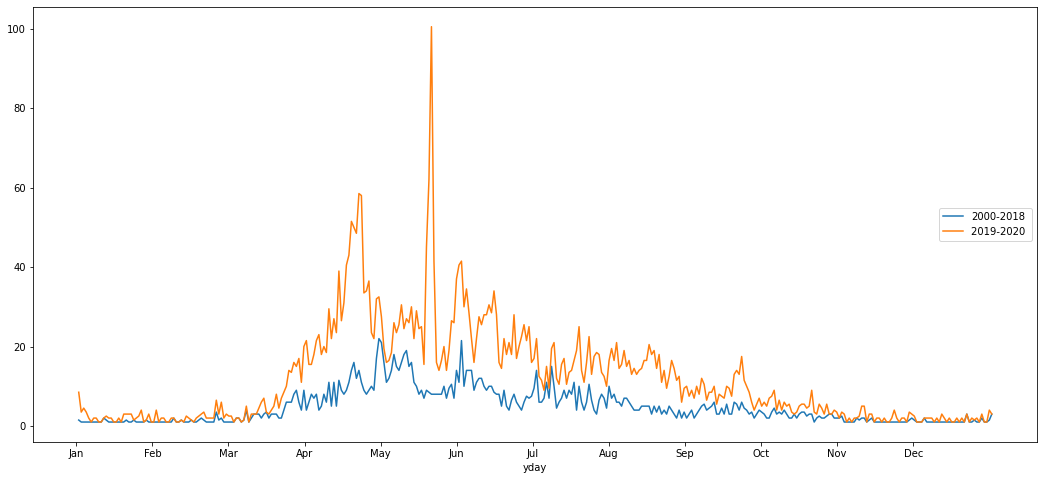

In [ ]:
line = fig4.plot(kind='line',y='Sum', stacked=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
line.legend(loc='center right')
plt.show()

In [ ]:
fig5 = fires_day_month_v2.groupby(['yday','year_group']).mean().unstack()
fig5

level_0                   index                   day  \
year_group    2000-2018 2019-2020     2000-2018 2019-2020   2000-2018   
yday                                                                    
1           3582.100000     4824.0  3582.100000     4824.0   1.000000   
2           3438.714286     4966.5  3438.714286     4966.5   2.000000   
3           3769.600000     4915.5  3769.600000     4915.5   3.000000   
4           3670.666667     4950.0  3670.666667     4950.0   4.000000   
5           3638.750000     5012.0  3638.750000     5012.0   5.000000   
...                 ...        ...          ...        ...        ...   
362         3197.500000     5013.0  3197.500000     5013.0  27.750000   
363         3692.166667        NaN  3692.166667        NaN  28.666667   
364         3393.750000        NaN  3393.750000        NaN  29.750000   
365         3590.000000     4957.5  3590.000000     4957.5  30.833333   
366         2639.000000        NaN  2639.000000        NaN  31.000000   

                          month                    Year                  Sum  \
year_group 2019-2020  2000-2018 2019-2020     2000-2018 2019-2020  2000-2018   
yday                                                                           
1                 1.0       1.0        1.0  2010.800000     2019.5  1.600000   
2                 2.0       1.0        1.0  2007.428571     2019.5  1.571429   
3                 3.0       1.0        1.0  2008.200000     2019.5  1.200000   
4                 4.0       1.0        1.0  2011.000000     2019.5  1.333333   
5                 5.0       1.0        1.0  2007.750000     2019.0  1.000000   
...               ...       ...        ...          ...        ...       ...   
362              27.0      12.0       12.0  2011.750000     2020.0  2.250000   
363               NaN      12.0        NaN  2011.166667        NaN  1.333333   
364               NaN      12.0        NaN  2013.750000        NaN  2.000000   
365              30.5      12.0       12.0  2013.666667     2019.5  1.500000   
366               NaN      12.0        NaN  2009.333333        NaN  4.000000   

                           rol7             
year_group 2019-2020  2000-2018 2019-2020   
yday                                        
1                 7.0  1.571429   2.214286  
2                 2.5  1.690476   2.428571  
3                 3.5  1.714286   2.714286  
4                 2.5  1.228571   2.928571  
5                 1.0  1.857143   2.428571  
...               ...       ...        ...  
362               1.0  1.607143   1.142857  
363               NaN  1.261905        NaN  
364               NaN  1.642857        NaN  
365               2.5  1.547619   1.285714  
366               NaN  1.904762        NaN  

[366 rows x 14 columns]

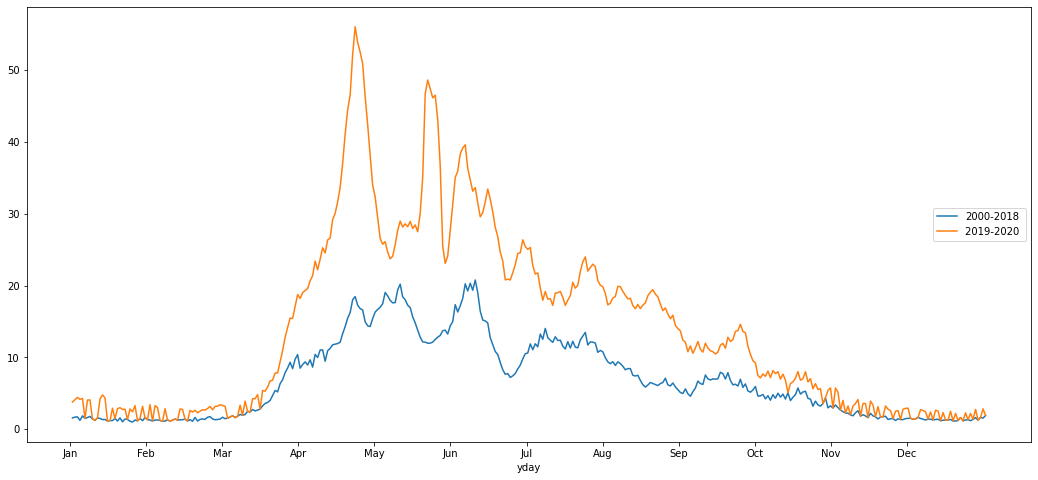

In [ ]:
line2 = fig5.plot(kind='line',y='rol7', stacked=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
line2.legend(loc='center right')
plt.show()

In [ ]:
fig2 = fires_day_month.drop(columns=['day','month','Year'])
fig2 = fires_day_month.groupby(['yday']).sum().unstack()

In [ ]:
line = fig.plot(kind='line',y='fires', stacked=True)
line.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
line.set_xticklabels(fires_month['Month'].values)
line.legend(loc='center right')

In [ ]:
#At this point we remove Latitude and Longitude NaNs. We could replace these with other values in the future maybe?
sample = sample[sample['Latitude'].notna()]
sample = sample[sample['Longitude'].notna()]


In [ ]:
with open('./data/sweden-municipalities-topo.json',encoding='utf-8') as f:
  muni_topo = json.load(f)

In [ ]:
muni_topo.keys()

dict_keys(['type', 'arcs', 'transform', 'objects'])

In [ ]:
muni_topo['objects'].keys()

dict_keys(['SWE_adm2'])

In [ ]:
muni_topo['objects']['SWE_adm2'].keys()

dict_keys(['type', 'geometries'])

In [ ]:
muni_topo['objects']['SWE_adm2']['geometries'][0].keys()

dict_keys(['arcs', 'type', 'properties'])

In [ ]:
muni_topo['objects']['SWE_adm2']['geometries'][0]['properties'].keys()

dict_keys(['ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2', 'HASC_2', 'TYPE_2', 'ENGTYPE_2', 'VARNAME_2'])

In [ ]:
muni_topo['objects']['SWE_adm2']['geometries'][1]['properties']['NAME_2']

'Åtvidaberg'

In [ ]:
fire_muni = sample
fire_muni = fire_muni[['datum','kommunKortNamn']]
fire_muni


datum kommunKortNamn
1      2000-01-01        Tranemo
3      2000-01-02      Stockholm
5      2000-01-04      Mariestad
6      2000-01-05       Vårgårda
7      2000-01-08      Ängelholm
...           ...            ...
100289 2020-12-14       Göteborg
100290 2020-12-17       Emmaboda
100292 2020-12-19      Söderhamn
100298 2020-12-27         Tyresö
100304 2020-12-30        Uppsala

[45922 rows x 2 columns]

In [ ]:
ssdd = pd.DataFrame(columns=['fires'])
tt = fire_muni.set_index(['datum'])
fire_muni_pre2019 = tt.loc['2000-01-01':'2018-12-31']
fire_muni_pre2019['year_group'] = '2000-2018'
fire_muni_post2018 = tt.loc['2019-01-01' : '2020-12-31']
fire_muni_post2018['year_group'] = '2019-2020'
fire_muni_fires12to18 = tt.loc['2012-01-01' : '2018-12-31']
fire_muni_post2018.sort_values(by='datum')
ssdd = pd.concat([fire_muni_pre2019,fire_muni_post2018])
ssdd = ssdd.assign(fires=1)
ssdd= ssdd.reset_index()



C:\Users\Johan\AppData\Local\Temp/ipykernel_11868/670432786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_muni_pre2019['year_group'] = '2000-2018'
C:\Users\Johan\AppData\Local\Temp/ipykernel_11868/670432786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_muni_post2018['year_group'] = '2019-2020'


In [ ]:
ssdd['kommunKortNamn'] = ssdd['kommunKortNamn'].replace('Malung','Malung-Sälen')
ssdd

datum kommunKortNamn year_group  fires
0     2000-01-01        Tranemo  2000-2018      1
1     2000-01-02      Stockholm  2000-2018      1
2     2000-01-04      Mariestad  2000-2018      1
3     2000-01-05       Vårgårda  2000-2018      1
4     2000-01-08      Ängelholm  2000-2018      1
...          ...            ...        ...    ...
45917 2020-12-14       Göteborg  2019-2020      1
45918 2020-12-17       Emmaboda  2019-2020      1
45919 2020-12-19      Söderhamn  2019-2020      1
45920 2020-12-27         Tyresö  2019-2020      1
45921 2020-12-30        Uppsala  2019-2020      1

[45922 rows x 4 columns]

In [ ]:
testest= ssdd.groupby(ssdd['kommunKortNamn']).sum()
testest =testest.reset_index()
testest

kommunKortNamn  fires
0              Ale    160
1         Alingsås    197
2          Alvesta    118
3            Aneby     24
4           Arboga     66
..             ...    ...
285      Österåker    249
286      Östhammar    126
287   Östra Göinge     78
288      Överkalix     55
289     Övertorneå     36

[290 rows x 2 columns]

In [ ]:
kommun = pd.DataFrame(columns=['NAME_2'])
kommun

Empty DataFrame
Columns: [NAME_2]
Index: []

In [ ]:
indx = []
with open('./data/sweden-municipalities-topo.json',encoding='utf-8') as json_file:
    data = json.load(json_file)
    obj = data['objects']
    for righe in obj["SWE_adm2"]['geometries']:
        print(righe['properties']['NAME_2'])
        indx.append(righe['properties']['NAME_2']) #print the name of the City

Ödeshög
Åtvidaberg
Boxholm
Finspång
Kinda
Linköping
Mjölby
Motala
Norrköping
Söderköping
Vadstena
Valdemarsvik
Ydre
Karlshamn
Karlskrona
Olofström
Ronneby
Sölvesborg
Älvdalen
Avesta
Borlänge
Falun
Gagnef
Hedemora
Leksand
Ludvika
Malung
Mora
Orsa
Rättvik
Säter
Smedjebacken
Vansbro
Bollnäs
Gävle
Hofors
Hudiksvall
Ljusdal
Nordanstig
Ockelbo
Ovanåker
Söderhamn
Sandviken
Gotland
Falkenberg
Halmstad
Hylte
Kungsbacka
Laholm
Varberg
Östersund
Åre
Berg
Bräcke
Härjedalen
Krokom
Ragunda
Strömsund
Aneby
Eksjö
Gislaved
Gnosjö
Jönköping
Nässjö
Sävsjö
Tranås
Värnamo
Vaggeryd
Vetlanda
Borgholm
Emmaboda
Högsby
Hultsfred
Kalmar
Mönsterås
Mörbylånga
Nybro
Oskarshamn
Torsås
Västervik
Vimmerby
Älmhult
Alvesta
Lessebo
Ljungby
Markaryd
Tingsryd
Uppvidinge
Växjö
Överkalix
Övertorneå
Älvsbyn
Arjeplog
Arvidsjaur
Boden
Gällivare
Haparanda
Jokkmokk
Kalix
Kiruna
Luleå
Pajala
Piteå
Örebro
Askersund
Degerfors
Hällefors
Hallsberg
Karlskoga
Kumla
Laxå
Lekeberg
Lindesberg
Ljusnarsberg
Nora
Eskilstuna
Flen
Gnesta
Katrin

In [ ]:
kk = pd.DataFrame(columns=['kommunKortNamn'])
kk['kommunKortNamn'] = fire_muni['kommunKortNamn']
kk['kommunKortNamn'] =kk['kommunKortNamn'].replace('Malung','Malung-Sälen')
kk = kk.drop_duplicates(subset='kommunKortNamn')
kk = kk.sort_values(by='kommunKortNamn')
kk = kk.reset_index()
kk


index kommunKortNamn
0      393            Ale
1     2550       Alingsås
2       52        Alvesta
3     6791          Aneby
4      314         Arboga
..     ...            ...
285   1553      Österåker
286    695      Östhammar
287   1238   Östra Göinge
288   3882      Överkalix
289   4137     Övertorneå

[290 rows x 2 columns]

In [ ]:
kommun['NAME_2'] = indx
kommun['NAME_2']

0              Ödeshög
1           Åtvidaberg
2              Boxholm
3             Finspång
4                Kinda
5            Linköping
6               Mjölby
7               Motala
8           Norrköping
9          Söderköping
10            Vadstena
11        Valdemarsvik
12                Ydre
13           Karlshamn
14          Karlskrona
15           Olofström
16             Ronneby
17          Sölvesborg
18            Älvdalen
19              Avesta
20            Borlänge
21               Falun
22              Gagnef
23            Hedemora
24             Leksand
25             Ludvika
26              Malung
27                Mora
28                Orsa
29             Rättvik
30               Säter
31        Smedjebacken
32             Vansbro
33             Bollnäs
34               Gävle
35              Hofors
36          Hudiksvall
37             Ljusdal
38          Nordanstig
39             Ockelbo
40            Ovanåker
41           Söderhamn
42           Sandviken
43         

In [ ]:
kommun = kommun.sort_values(by='NAME_2')
kommun = kommun.reset_index()

In [ ]:
kommun['kommunKortNamn'] = kk['kommunKortNamn']
pd.set_option('display.max_rows', 10)
kommun
grouped_ssdd['kommunKortNamn']= ssdd.groupby(['kommunKortNamn']).sum()
grouped_ssdd = grouped_ssdd.dropna()


In [425]:

folium.Choropleth(geo_data=states_topo,
    topojson='objects.SWE_adm2',
    key_on='feature.properties.NAME_2',
    data=testest, # my dataset
    columns=['kommunKortNamn','fires'], 
    fill_color='GnBu', 
    fill_opacity=0.4, 
    line_opacity=0.5).add_to(m)
m

In [110]:
#Function that takes the dataframe and returns a map. Circles on the map are colored based on the size of the fire.
def add_FireCircle(df, m):
    for i, v in df.iterrows():
        
        fire_size = float(v['Acres'])
        
        #When hoovering over the circle, the popup will show the fire name, year, cause, state and size.
        #More values can be added.
        popup = """
        Kommun : <b>%s</b><br>
        Size (Acres) : <b>%s</b><br>
        Cause : <b>%s</b><br>
        Year: <b>%s</b><br>
        """ % (v['kommunKortNamn'], v['Acres'], 
            v['BEJBbrandorsakText'], 
            v['ar'])
        
        
        if fire_size < 100:
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 0.8,
                            weight = 0,
                            tooltip = popup,
                            color = '#ffeda0',
                            fill_color = '#ffeda0',
                            fill_opacity = 0.7,
                            fill = True).add_to(small_wildfires)
            
        if fire_size in range(100, 500):
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size),
                            weight = 0,
                            tooltip = popup,
                            color = '#feb24c',
                            fill_color = '#feb24c',
                            fill_opacity = 0.7,
                            fill = True).add_to(medium_wildfires)
        
        if fire_size in range(1000, 5000):
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 1.5,
                            weight = 0,
                            tooltip = popup,
                            color = '#fc4e2a',
                            fill_color = '#fc4e2a',
                            fill_opacity = 0.7,
                            fill = True).add_to(large_wildfires)

        if fire_size > 5000:
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 2,
                            weight = 0,
                            tooltip = popup,
                            color = '##b10026',
                            fill_color = '#b10026',
                            fill_opacity = 0.7,
                            fill = True).add_to(xl_wildfires)

    small_wildfires.add_to(m)
    medium_wildfires.add_to(m)
    large_wildfires.add_to(m)
    xl_wildfires.add_to(m)
    folium.LayerControl(collapsed = False).add_to(m)

    return m

In [111]:
#Map instanciation, with start point at the center of Sweden. Type of map is set to Stamen Terrain and zoom is set to 5.5 in the beginning.
map = folium.Map(location = [59.334591, 18.063240],
               tiles = 'Stamen Terrain',
               zoom_start = 5.5)

In [112]:
#Creating Ciricle map (FYI! Can take som time!)
m_sweden = add_FireCircle(sample, map)
m_sweden.save('sweden.html')

ValueError: Location values cannot contain NaNs.

In [295]:
#Creating heatmap for sample
locations = sample[['Latitude','Longitude']]
h_sweden = add_ToHeatMap(locations.values,map)

In [298]:
h_sweden